# Spark Streaming
Spark Streaming is an extension to Spark Core which provides scalable, high-throughput, fault-tolerant stream processing. It is built on top of the Spark Core API and helps us to process unbounded streaming data. It uses micro batching and windowing techniques to process streaming data. Spark Streaming provides the following benefits: 
* Fast recovery from failures and stragglers
* Better load balancing and resource usage
* Combination of streaming data with static datasets and interactive queries
* Join one data stream with another data stream
* Native integration with advanced processing libraries (SQL, machine learning, graph processing)

## Spark Streaming Architecture
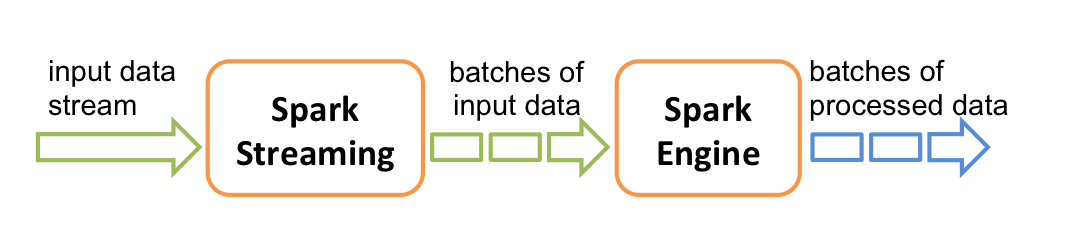

Spark Streaming takes the input data from streaming sources such as Kafka, Kinesis, or Twitter and divides the data into chunks. These chunks, also called micro batches, are then processed by the Spark Engine to generate a stream of result batches. 

Traditional stream processing frameworks use continuous operators to handle streaming data. These operators process one record at a time and pass it to the next operator in the pipeline. The source operator receives data from an external source like Kafka and the sink operator stores data into an external system like HDFS. This process is shown in the following illustration:

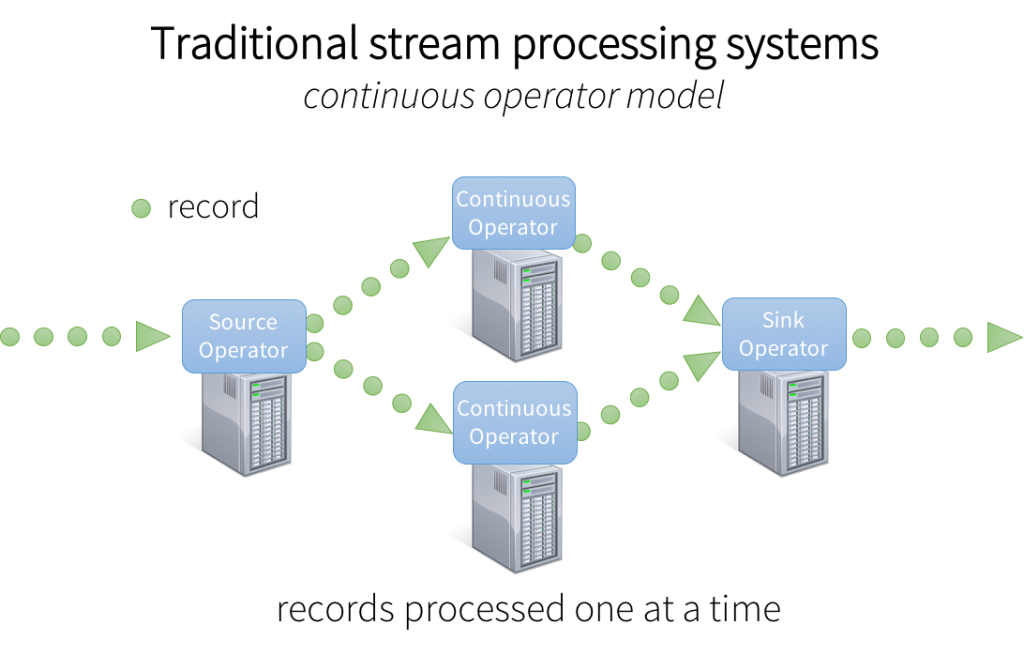


Spark does not process one record at a time as opposed to traditional continuous operators, rather it discretizes streams into tiny micro batches. Spark receives data from streaming sources, buffers it in memory, and then runs all the operators in the job over these micro batches. Each batch is stored in an RDD which makes it flexible to run any Spark function over it. 

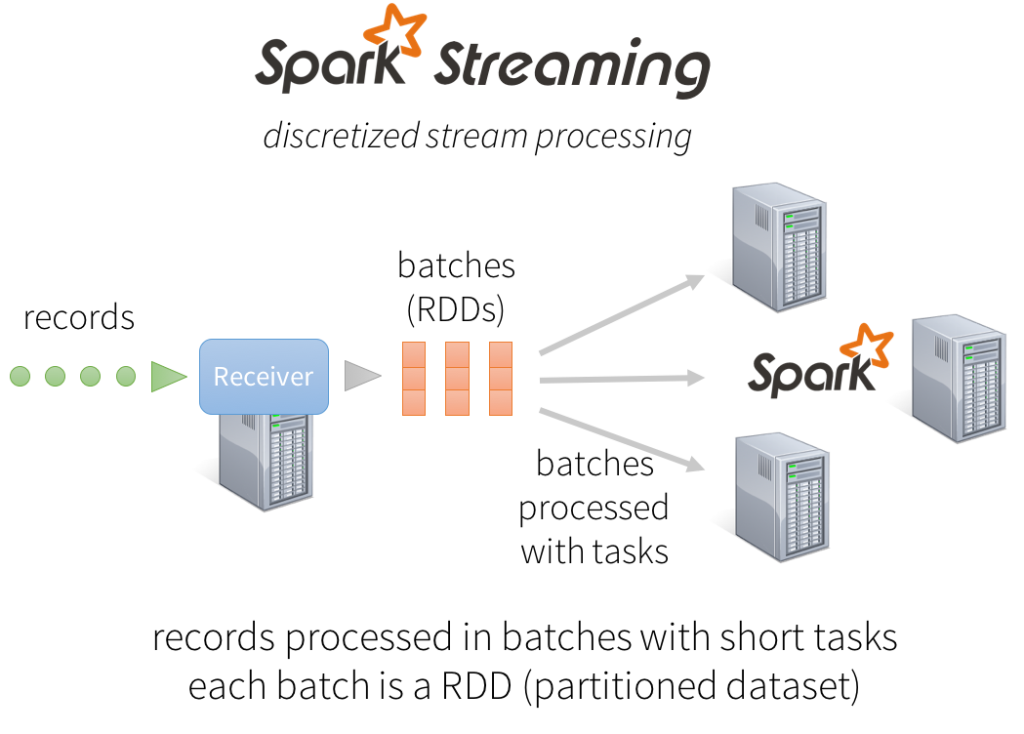


## Spark Streaming Job Definition
* Define streaming context
* Setup a streaming source 
* Define computations and output operations
* Start the streaming job

Once we define a workflow and start the streaming job, we cannot add or modify the operations in the workflow. If we want to change the operations, we need to kill the job and restart the streaming job after the modifications. We cannot have multiple streaming contexts in the same JVM.

## Example Application
The following example uses PySpark Streaming to build a word count application.

Open a terminal and run the following command:

*nc -lk 9999*

![nc-lk](nc-lk.png)


The input that you write here, will be gathered using the following code:

In [6]:
sc.stop()

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext

# create a SparkContext to connect to a Spark cluster
conf = SparkConf().setMaster('local').setAppName('myApp')
sc = SparkContext(conf=conf)

# create streaming context with batch interval of 5 seconds
ssc = StreamingContext(sc, 1)
# set source of streaming job, here it is a socket stream that will connect on localhost with port 9999
rawStream = ssc.socketTextStream("localhost", 9999)

# apply flatmap and then map to map each word in the line by 1
wordStream = rawStream.flatMap(lambda line: line.split(" ")).map(lambda x: (x, 1))
# count occurences of each word and print
wordStream.reduceByKey(lambda x, y: x + y).pprint()

# start the stream
ssc.start()      
ssc.awaitTerminationOrTimeout(3)

# clean up
ssc.stop()
sc.stop()

-------------------------------------------
Time: 2019-02-04 11:34:08
-------------------------------------------

-------------------------------------------
Time: 2019-02-04 11:34:09
-------------------------------------------

-------------------------------------------
Time: 2019-02-04 11:34:10
-------------------------------------------



# Spark Streaming Concepts
### DStreams
DStreams are a continuous series of RDDs representing a stream of data. It can be created from some external streaming source or by applying some transformation over an existing DStream. Each RDD contains data from a specific batch as shown below.
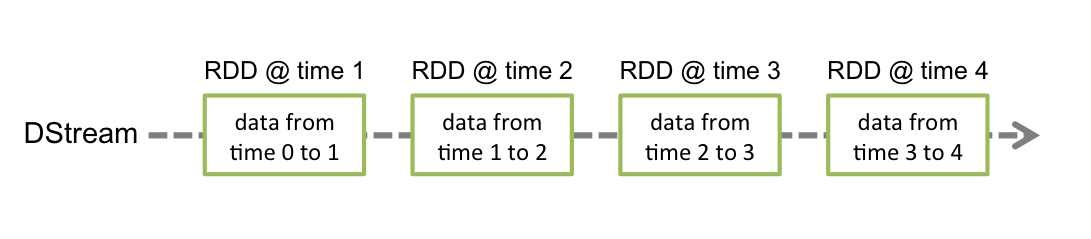


### Micro Batch 
Micro batch is a core concept used by Spark. Micro batching takes the incoming data and buffers it for a given time interval. It creates one batch of all those records within the same time interval. In case of incoming streams, events can be packed into various small batches and then delivered to a batch system for processing.

### Stateful Transformations
Stateful transformations are calculated on multiple batches. The result from a previous batch is kept in memory and used in the next batch computation. For example, if we want to perform a moving average over all the data batches, we need to save the average over all the batches. Spark provides stateful transformations such as *updateStateByKey* and window operations. The state can also be spilled to disk to reduce memory overhead. The programmers need to define what will be stored in the state and how it will be updated.

### Window Operations
Spark Streaming provides window computations, which allow you to apply transformations over a sliding window of data. The following image illustrates the windowing concept.

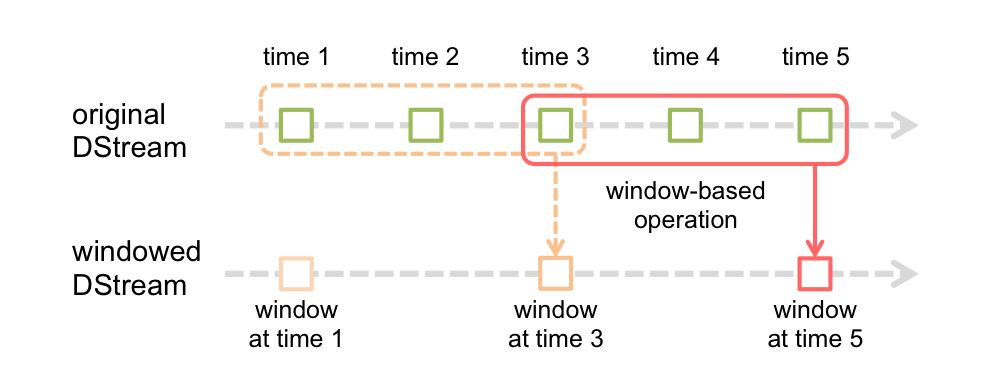

In the example, the window interval is three time units and the sliding interval is two time units. All operations are performed on RDDs of the window data of three time units. The window interval and sliding interval need to be a multiple of the batch interval. Spark provides a range of windowing operations such as *countByWindow* and *reduceByWindow*.

The following examples, show how to use the state and windowing operations.
Let's have some practical experience with state and windowing operations.

In [5]:
# define the update state function
def updateState(currentCount, countState):
    if countState is None:
        countState = 0
    return sum(currentCount, countState)


from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext

# create a SparkContext to connect to a Spark cluster
conf = SparkConf().setMaster('local').setAppName('myApp2')
sc = SparkContext(conf=conf)

# create streaming context with batch interval of 2 seconds
ssc = StreamingContext(sc, 2)

# define checkpointing directory.
ssc.checkpoint("/tmp")

# set source of streaming job, here it is a socket stream that will connect on local host with port 9999
rawStream = ssc.socketTextStream("localhost", 9999)

#apply flatmap and then map to map each word in the line by 1
wordStream = rawStream.flatMap(lambda line: line.split(" ")).map(lambda x: (x,1))
#count occurances of each word
wordCounts = wordStream.reduceByKey(lambda x, y: x + y)

#total count against each word so far and print
totalCounts = wordCounts.updateStateByKey(updateState).pprint()

#start streaming
ssc.start()
ssc.awaitTermination(6)

ssc.stop()
sc.stop()

-------------------------------------------
Time: 2019-02-04 11:36:24
-------------------------------------------

-------------------------------------------
Time: 2019-02-04 11:36:26
-------------------------------------------
('d', 4)
('*', 5)
('Fast', 1)
('recovery', 1)
('from', 1)
('failures', 1)
('and', 3)
('stragglers', 1)
('Better', 1)
('load', 1)
...

-------------------------------------------
Time: 2019-02-04 11:36:28
-------------------------------------------
('d', 4)
('*', 5)
('Fast', 1)
('recovery', 1)
('from', 1)
('failures', 1)
('and', 3)
('stragglers', 1)
('Better', 1)
('load', 1)
...

-------------------------------------------
Time: 2019-02-04 11:36:30
-------------------------------------------
('d', 4)
('*', 5)
('Fast', 1)
('recovery', 1)
('from', 1)
('failures', 1)
('and', 3)
('stragglers', 1)
('Better', 1)
('load', 1)
...



In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext

# create a SparkContext to connect to a Spark cluster
conf = SparkConf().setMaster('local').setAppName('myApp3')
sc = SparkContext(conf=conf)

# create streaming context with batch interval of 2 seconds
ssc = StreamingContext(sc, 2)

# set source of streaming job, here it is a socket stream that will connect on local host with port 9999
rawStream = ssc.socketTextStream("localhost", 9999)

# window stream of 6 seconds and sliding after 4 seconds
windowStream = rawStream.window(6, 4)

#apply flatmap and then map to map each word in the line by 1
wordsStream=windowStream.flatMap(lambda line: line.split(" ")).map(lambda x: (x,1))

#count occurances of each word and print
wordsStream.reduceByKey(lambda x, y: x + y).pprint()

#start streaming
ssc.start()
ssc.awaitTermination(12)

ssc.stop()
sc.stop()

-------------------------------------------
Time: 2019-02-04 11:35:48
-------------------------------------------
('', 1)
('*', 5)
('Fast', 1)
('recovery', 1)
('from', 1)
('failures', 1)
('and', 3)
('stragglers', 1)
('Better', 1)
('load', 1)
...

-------------------------------------------
Time: 2019-02-04 11:35:52
-------------------------------------------
('', 1)
('*', 10)
('Fast', 2)
('recovery', 2)
('from', 2)
('failures', 2)
('and', 6)
('stragglers', 2)
('Better', 2)
('load', 2)
...

-------------------------------------------
Time: 2019-02-04 11:35:56
-------------------------------------------
('a', 3)



## References
1. [diving-into-apache-spark-streamings-execution-model](https://databricks.com/blog/2015/07/30/diving-into-apache-spark-streamings-execution-model.html)
2. [streaming-programming-guide](https://spark.apache.org/docs/latest/streaming-programming-guide.html)
3. https://www.simplilearn.com/spark-streaming-tutorial-video
    